In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /root/.kaggle
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:13<00:00, 89.0MB/s]
100% 1.33G/1.33G [00:13<00:00, 106MB/s] 


In [ ]:
!mkdir celeba
!mv celeba-dataset.zip celeba

In [ ]:
%cd celeba
!unzip -q celeba-dataset.zip
%cd ..

/content/celeba
/content


In [ ]:
!cp /content/drive/MyDrive/celebAgreyscale/celeba/*.txt /content/celeba

In [ ]:
!mv /content/celeba/img_align_celeba /content/celeba/img_align_celeba_2
!mv /content/celeba/img_align_celeba_2/img_align_celeba /content/celeba/img_align_celeba

In [ ]:
!mkdir celebaholder
!mv celeba celebaholder

In [ ]:
%%bash
git clone https://github.com/AntixK/PyTorch-VAE
cd PyTorch-VAE
pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.4/525.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 42.2 MB/s eta 0:00:00


Cloning into 'PyTorch-VAE'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
%cd PyTorch-VAE

/content/PyTorch-VAE


In [ ]:
!pip install lmdb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
from models.vq_vae import VQVAE
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch import nn
import math
import os
import matplotlib.pyplot as plt
import random

In [ ]:
transform = transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CelebA(root='/content/celebaholder', split = "test",
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

In [ ]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [ ]:
# Sinusoidal Time Embedded Conditioned Feed Forward Network
class STEFF(nn.Module):
  def __init__(self, max_time_steps, input_dim, depth, act_fn):
    super().__init__()
    self.ff = nn.ModuleList()
    for _ in range(depth):
      self.ff.append(nn.Sequential(nn.Linear(input_dim, input_dim), act_fn()))
    self.depth = depth
    self.emb = SinusoidalPosEmb(input_dim)
    self.max_time_steps = max_time_steps
  def forward(self, X, T):
    nX = X
    for i in range(self.depth):
      nX = nX + (self.ff[i](nX * self.emb(T / self.max_time_steps)))
    return nX
# Learned Time Embedded Conditioned Feed Forward Network
class LTEFF(nn.Module):
  def __init__(self, max_time_steps, input_dim, depth, act_fn):
    super().__init__()
    self.ff = nn.ModuleList()
    for _ in range(depth):
      self.ff.append(nn.Sequential(nn.Linear(input_dim, input_dim), act_fn()))
    self.depth = depth
    self.emb = nn.Embedding(max_time_steps, input_dim)
    self.max_time_steps = max_time_steps
  def forward(self, X, T):
    nX = X
    cX = self.emb(T.int())
    for i in range(self.depth):
      nX = nX + (self.ff[i](nX) * cX)
    return nX

In [ ]:
def linear_projection(iX, oX, T):
  return iX + (oX - iX) * torch.reshape(T, (-1,1))

In [ ]:
device = 'cuda'


max_steps = 50
latent_dim = 32*16*16
max_depth = 8

vae = VQVAE(in_channels = 3, embedding_dim = 32, num_embeddings = 512, latent_dim = 128, num_classes = 2, beta = 0.25)
vae.load_state_dict(torch.load('/content/drive/MyDrive/celebAgreyscale/vae_32_16_16.pt'))
vae.to(device)
vae.eval()

act_fn = nn.ReLU
lcdm = STEFF(max_steps, latent_dim, max_depth, act_fn)
lcdm.load_state_dict(torch.load('/content/drive/MyDrive/celebAgreyscale/STEFF_8_RELU.pt'))
lcdm.to(device)
lcdm.eval()

STEFF(
  (ff): ModuleList(
    (0-7): 8 x Sequential(
      (0): Linear(in_features=8192, out_features=8192, bias=True)
      (1): ReLU()
    )
  )
  (emb): SinusoidalPosEmb()
)

In [ ]:
def RRMSE(y, yh):
  return (torch.sqrt(torch.mean((y - yh) ** 2)) / torch.mean(torch.sqrt(y ** 2))).item()

In [ ]:
def MAPE(y, yh):
  return torch.mean(torch.abs(y - yh) / torch.abs(y)).item()

In [ ]:
def sample_ddm_improved(x_T, max_T, lcdm, device):
  px_s = x_T
  x_0 = x_T
  for s in range(1, max_T, 1):
    S = (torch.ones(size = (B,)) * s).to(device)
    x_0 = lcdm(px_s, S)
    px_s = px_s - linear_projection(x_0, x_T, S / max_T) + linear_projection(x_0, x_T, (S - 1) / max_T)
  return px_s

In [ ]:
full_test = list(iter(testloader))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
data, labels = full_test[3]

with torch.no_grad():
  color = data.to(device)
  grayscale = torchvision.transforms.Grayscale(num_output_channels=3)(color).to(device)
  color_embeds = torch.flatten(vae.encode(color)[0], start_dim = 1)
  grayscale_embeds = torch.flatten(vae.encode(grayscale)[0], start_dim = 1)
  B = grayscale_embeds.size()[0]
  T = torch.randint(low = 0, high = max_steps, size = (B,), dtype = torch.float32).to(device)
  starting_positions = linear_projection(grayscale_embeds, color_embeds, T / max_steps)
  dec = lcdm(grayscale_embeds, torch.ones(size = (B,)).to(device))

  dec_improved = sample_ddm_improved(grayscale_embeds, max_steps, lcdm, device)

  recon_color_data = vae.decode(torch.reshape(dec, (64, 32, 16, 16)))
  recon_color_data_improved = vae.decode(torch.reshape(dec_improved, (64, 32, 16, 16)))
  recon_grayscale = vae.decode(torch.reshape(grayscale_embeds, (64, 32, 16, 16)))
  recon_color = vae.decode(torch.reshape(color_embeds, (64, 32, 16, 16)))

In [ ]:
MAPE(color_embeds, dec_improved), MAPE(color_embeds, dec)

(13.356698036193848, 15.399053573608398)

In [ ]:
F.mse_loss(color, recon_color_data_improved).item(), F.mse_loss(color, recon_color_data).item()

(0.03091086447238922, 0.030485039576888084)

Text(0.5, 1.0, 'Color Recon')

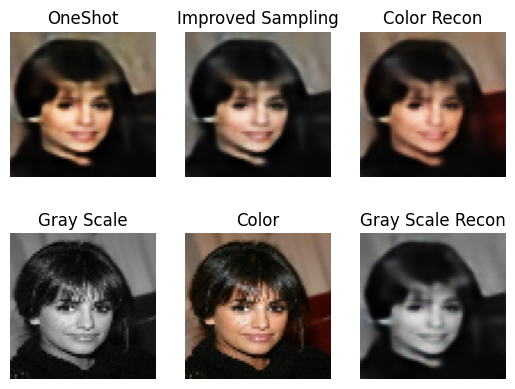

In [ ]:
i = random.randint(0, 63)
# recon_color_data_improved = vae.decode(torch.reshape(dec_improved, (64, 32, 16, 16)))
color_recon_img = ((recon_color_data[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
color_recon_img_improved = ((recon_color_data_improved[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
grayscale_recon_img = ((recon_grayscale[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
color_img = ((color[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
grayscale_img = ((grayscale[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
true_color_recon_img = ((recon_color[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()

# recons = torch.cat((color_recon_img, color_recon_img_improved), 1)
# origs = torch.cat((color_img, grayscale_img), 1)
# plt.imshow(torch.cat((recons, origs), 0))

fig, axs = plt.subplots(2, 3)

axs[0, 0].imshow(color_recon_img)
axs[0,0].axis("off")
axs[0,0].set_title("OneShot")

axs[0, 1].imshow(color_recon_img_improved)
axs[0, 1].axis("off")
axs[0, 1].set_title("Improved Sampling")

axs[1, 1].imshow(color_img)
axs[1, 1].axis("off")
axs[1, 1].set_title("Color")

axs[1, 0].imshow(grayscale_img)
axs[1, 0].axis("off")
axs[1, 0].set_title("Gray Scale")

axs[1, 2].imshow(grayscale_recon_img)
axs[1, 2].axis("off")
axs[1, 2].set_title("Gray Scale Recon")

axs[0, 2].imshow(true_color_recon_img)
axs[0, 2].axis("off")
axs[0, 2].set_title("Color Recon")

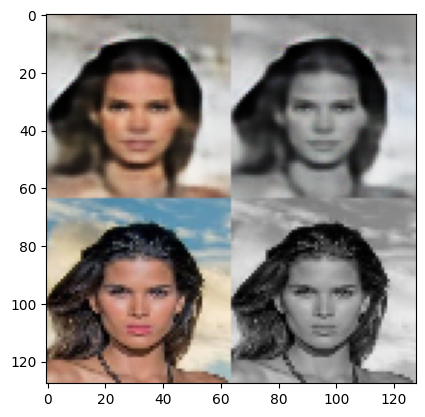

In [ ]:
i = random.randint(0, 63)
color_recon_img = ((recon_color_data[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
grayscale_recon_img = ((recon_grayscale[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
color_img = ((color[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
grayscale_img = ((grayscale[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()

recons = torch.cat((color_recon_img, grayscale_recon_img), 1)
origs = torch.cat((color_img, grayscale_img), 1)
plt.imshow(torch.cat((recons, origs), 0))